In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time

* mlp from scratch in python
* [following this guide/walk through of building an mlp from scratch](https://github.com/KirillShmilovich/MLP-Neural-Network-From-Scratch)
* MNIST images are 28x28 pixels

In [2]:
def load_data(dir_name):
    data = list()
    
    with open(dir_name, "r") as f:
        for line in f:
            split_line = np.array(line.split(",")) # split data in row
            split_line = split_line.astype(np.float32) # str to float
            data.append(split_line)
    
    data = np.asarray(data) # data list to numpy array
    
    return data[:,1:], data[:,0] # first num in each sample is the label so return X and Y components

In [8]:
X_train, Y_train = load_data("data/mnist_train.csv")
X_test, Y_test = load_data("data/mnist_test.csv")

In [9]:
print(f"Shape of training set: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"Shape of testing set: {X_test.shape[0]} x {X_test.shape[1]}")

Shape of training set: 60000 x 784
Shape of testing set: 10000 x 784


In [12]:
# rescale data from 0-255 to 0.0-1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encode train/test labels (convert 0-9 to binary vector representation)
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size), Y_train.astype(int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size), Y_test.astype(int)] = 1.0

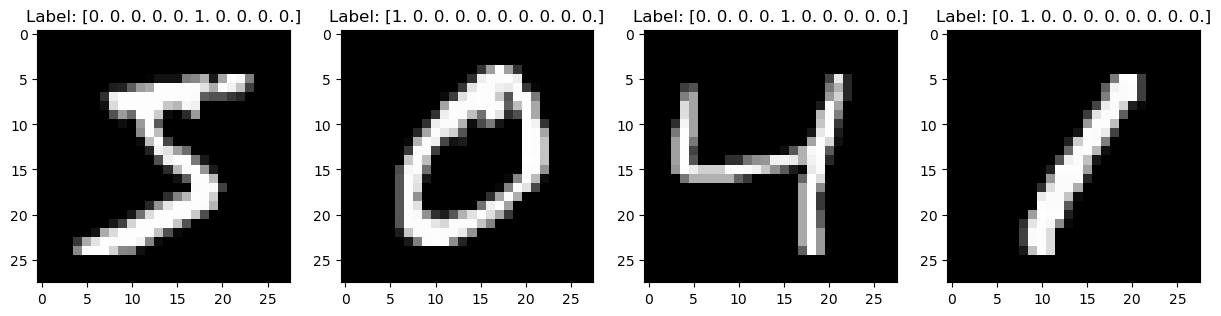

In [13]:
n = 4
fig, axes = plt.subplots(1, n, figsize=(15,10))
for image, label, ax in zip(X_train[:n], y_train[:n], axes):
    ax.imshow(image.reshape(28,28), cmap="gray", vmin=0, vmax=1.0)
    ax.set_title(f"Label: {label}")

In [62]:
class MLP:
    def __init__(self, X, Y, X_val, Y_val, L=1, N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self, x):
        return 1./(1.+np.exp(-x))

    def __sigmoid_prime(self, h):
        return h*(1-h)

    def __softmax(self, x):
        exp = np.exp(x)
        return exp/exp.sum(axis=1, keepdims=True)
    
    def __loss(self, y, y_pred):
        # compute loss along rows and average along the num of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self, y, y_pred):
        return np.all(y == y_pred, axis=1).mean()
    
    def __to_categorical(self, x):
        categorical = np.zeros((x.shape[0], self.Y.shape[1]))
        categorical[np.arange(x.shape[0]), x.argmax(axis=1)] = 1
        return categorical
    
    # init the layers so we can store the calculations and more easily perform the backword pass
    def __init_layers(self, batch_size):
        self.__h = [np.empty((batch_size, layer_size)) for layer_size in self.layer_sizes]

    # init weights with random number from -1.0 to 1.0
    def __init_weights(self):
        self.weights = []
        #self.weights = list()
        for i in range (self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1, 1, size=[self.layer_sizes[i], self.layer_sizes[i+1]]))
        #self.weights = np.asarray(self.weights)
    
    def __feed_forward(self, batch):
        h_l = batch
        self.__h[0] = h_l
        for i, weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1] = h_l
        self.__out = self.__softmax(self.__h[-1]) # softmax on output layer to get predicted label

    def __back_prop(self, batch_y):
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1]) # calculate error
        for i in range(1, len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)

    def evaluate(self, X, Y):
        prediction = self.predict(X)
        return self.__accuracy(prediction, Y)

    def train(self, batch_size=8, epochs=25, lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")

In [59]:
model = MLP(X_train, Y_train, X_test, Y_test, L=1, N_l=128)
model.train(batch_size=8, epochs=25, lr=1.0)

/tmp/ipykernel_143582/1496349083.py:32: RuntimeWarning: divide by zero encountered in log
  return ((-np.log(y_pred))*y).sum(axis=1).mean()


Epoch 1: loss = inf | acc = 0.82 | val_loss = inf | val_acc = 0.851 | train_time = 4.172 | tot_time = 4.217
Epoch 2: loss = inf | acc = 0.86 | val_loss = inf | val_acc = 0.864 | train_time = 4.294 | tot_time = 4.338
Epoch 3: loss = inf | acc = 0.869 | val_loss = inf | val_acc = 0.871 | train_time = 4.489 | tot_time = 4.534
Epoch 4: loss = inf | acc = 0.875 | val_loss = inf | val_acc = 0.875 | train_time = 5.485 | tot_time = 5.53
Epoch 5: loss = inf | acc = 0.879 | val_loss = inf | val_acc = 0.876 | train_time = 6.324 | tot_time = 6.398
Epoch 6: loss = inf | acc = 0.883 | val_loss = inf | val_acc = 0.88 | train_time = 4.623 | tot_time = 4.667
Epoch 7: loss = inf | acc = 0.885 | val_loss = inf | val_acc = 0.881 | train_time = 4.605 | tot_time = 4.649
Epoch 8: loss = inf | acc = 0.887 | val_loss = inf | val_acc = 0.881 | train_time = 4.729 | tot_time = 4.775
Epoch 9: loss = inf | acc = 0.889 | val_loss = inf | val_acc = 0.881 | train_time = 5.038 | tot_time = 5.085
Epoch 10: loss = inf | 

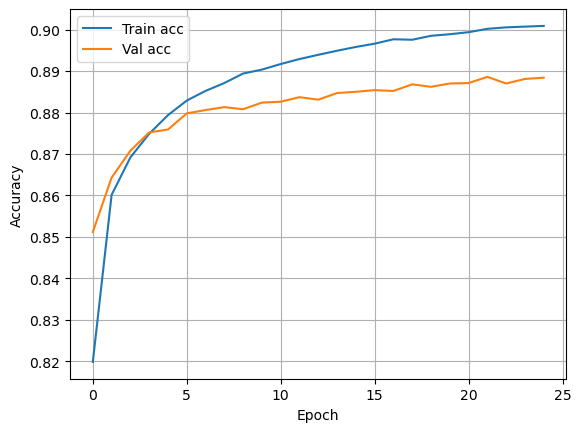

In [60]:

plt.plot(model.train_acc,label="Train acc")
plt.plot(model.val_acc,label="Val acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()